# 5 Min Binary Options Predictions on FX

## Import required libraries to train deep nerual network

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
#import tensorflow
import time

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from sklearn import preprocessing

print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)
#print('Tensorflow-gpu version: ' + tensorflow.__version__)

Using TensorFlow backend.


Numpy version: 1.16.4
Pandas version: 0.24.2
Matplotlib version: 3.1.0
Sklearn version: 0.21.2
Keras version: 2.2.4


## Class object to measure time

In [2]:
class MeasureTime:
    def __init__(self):
        self.start = time.time()
    def kill(self):
        print ('Time elapsed: ' + time.strftime("%H:%M:%S", time.gmtime(time.time()-self.start)))
        del self

In [3]:
Notebook_timer = MeasureTime()

#  

# Part 1. - Import data

# Feature engineering function

    1. Convert OHLC data in to wicks and body sizes of candle stick, also type of candle (Bear or Bull)
    2. Convert datetime in to weekday , hour and minute.
    3. Calculate RSI
    4. Calculate MACD
    5. Calculate Bolinger Bands
    6. Reshape dataframe (Create 10 more columns with last 10 candle data)
    7. Create columns with 11th candle type data (Bear or Bull)
    8. Delete OHLC and datetime data
    9. Convert to numpay array and return

### RSI function - Relative strength index

In [4]:
def relative_strength(prices, n=14):

    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi

### MA function - Moving average

In [5]:
def moving_average(x, n, type='simple'):

    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a

### MACD function - Moving average covergance divergance

In [6]:
def moving_average_convergence(x, nslow=26, nfast=12):
    
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow

## Main feature enginering function

In [7]:
def FeatureEnginering(MyRawData):

    #calculate time series
    #MyRawData['WeekDay'] = ((pd.to_datetime(MyRawData['Gmt time'], format='%d.%m.%Y %H:%M:%S.000', utc=True)).dt.dayofweek.astype(dtype=np.int64)/4)
    MyRawData['Gmt time'] = pd.to_datetime(MyRawData['Gmt time'], format='%d.%m.%Y %H:%M:%S.000', utc=True)
    #MyRawData['Gmt time'] = MyRawData['Gmt time'].dt.datetime
    #MyRawData['Gmt time'] = pd.to_datetime(MyRawData['Gmt time'])
    MyRawData['WeekDay'] = (MyRawData['Gmt time'].dt.dayofweek.astype(dtype=np.int64)/4)
    MyRawData['Hour'] = (MyRawData['Gmt time'].dt.hour.astype(dtype=np.int64)/23)
    MyRawData['Minute'] = (MyRawData['Gmt time'].dt.minute.astype(dtype=np.int64)/59)
    print('Step 1: Time conversion to Weekday, Hour, Minute')
    
    
   
    
    #calculate candle size parameters in pips
    MyRawData['BodyPips'] = abs((MyRawData['Open']-MyRawData['Close']) * 10000)
    MyRawData['WickUpPips'] = (abs(MyRawData['Open']-MyRawData['High']) * 10000)
    MyRawData['WickDownPips'] = (abs(MyRawData['Close']-MyRawData['Low']) * 10000)
    #calculate candle type
    MyRawData['type'] = 0
    MyRawData.loc[MyRawData['Close'] > MyRawData['Open'] , 'type'] = 1
    print('Step 2: Calculation Body,Wicks sizes and type of candle')
    
    MyRawData['EmaSlow'], MyRawData['EmaFast'], MyRawData['MACD'] = moving_average_convergence(MyRawData['Close'].values, nslow=26, nfast=12)                   
    print('Step 3: Calculate MACD')
    MyRawData['Ema9'] = moving_average(MyRawData['MACD'].values, 9, type='exponential')
    print('Step 4: Calculate EMA 9')
    MyRawData['RSI'] = relative_strength(MyRawData['Close'].values) 
    print('Step 5: Calculate RSI')

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    MyRawData['Rolling Mean'] = MyRawData['Close'].rolling(window=21).mean()
    MyRawData['Bollinger High'] = MyRawData['Close'].rolling(window=21).mean() + (MyRawData['Close'].rolling(window=21).std() * 2)
    MyRawData['Bollinger Low'] = MyRawData['Close'].rolling(window=21).mean() - (MyRawData['Close'].rolling(window=21).std() * 2)
    print('Step 6: Calculate Bolinger Bands')
    
    #add 10 more history candle sticks
    for CandleCount in range(10):
        ActualCandleCount = CandleCount + 1
        MyRawData['BodyPips' + '_' + str(ActualCandleCount)] = MyRawData['BodyPips'].shift(-ActualCandleCount)
        MyRawData['WickUpPips' + '_' + str(ActualCandleCount)] = MyRawData['WickUpPips'].shift(-ActualCandleCount)
        MyRawData['WickDownPips' + '_' + str(ActualCandleCount)] = MyRawData['WickDownPips'].shift(-ActualCandleCount)
        MyRawData['WeekDay' + '_' + str(ActualCandleCount)] = MyRawData['WeekDay'].shift(-ActualCandleCount)
        MyRawData['Hour' + '_' + str(ActualCandleCount)] = MyRawData['Hour'].shift(-ActualCandleCount)
        MyRawData['Minute' + '_' + str(ActualCandleCount)] = MyRawData['Minute'].shift(-ActualCandleCount)
        MyRawData['type' + '_' + str(ActualCandleCount)] = MyRawData['type'].shift(-ActualCandleCount)
        MyRawData['EmaSlow' + '_' + str(ActualCandleCount)] = MyRawData['EmaSlow'].shift(-ActualCandleCount)
        MyRawData['EmaFast' + '_' + str(ActualCandleCount)] = MyRawData['EmaFast'].shift(-ActualCandleCount)
        MyRawData['MACD' + '_' + str(ActualCandleCount)] = MyRawData['MACD'].shift(-ActualCandleCount)
        MyRawData['Ema9' + '_' + str(ActualCandleCount)] = MyRawData['Ema9'].shift(-ActualCandleCount)
        MyRawData['RSI' + '_' + str(ActualCandleCount)] = MyRawData['RSI'].shift(-ActualCandleCount)
        MyRawData['Rolling Mean' + '_' + str(ActualCandleCount)] = MyRawData['Rolling Mean'].shift(-ActualCandleCount)
        MyRawData['Bollinger High' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger High'].shift(-ActualCandleCount)
        MyRawData['Bollinger Low' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger Low'].shift(-ActualCandleCount)
        print('Step 7: Generating candle backwards [Candle: ' + str(ActualCandleCount) +']')

    #populate las column with the output
    MyRawData['output'] = 0
    MyRawData.loc[MyRawData['Close'] < MyRawData['Close'].shift(5), 'output'] = 1
    print('Step 8: Generating prediction column')
    

    #del MyRawData['Gmt time']
    del MyRawData['Open']
    del MyRawData['High']
    del MyRawData['Low']
    del MyRawData['Close']
    del MyRawData['Volume']
    print('Step 9: Deleting waste columns')

    return MyRawData[50:-50]



#  

# Import data from CSV to Pandas

In [68]:
%%time
#ddf_pd = pd.read_csv('EURUSD_2010_2018.csv',nrows=3000000)
ddf_pd = pd.read_csv('EURUSD_2010_2018.csv')
ddf_pd=ddf_pd[::-1]
ddf_pd=ddf_pd.head(400000)

CPU times: user 4.82 s, sys: 342 ms, total: 5.17 s
Wall time: 7.69 s


## Raw data

In [69]:
ddf_pd

,Gmt time,Open,High,Low,Close,Volume
3363312,31.12.2018 22:00:00.000,1.14644,1.14644,1.14627,1.14627,5.25
3363311,31.12.2018 21:59:00.000,1.14671,1.14671,1.14635,1.14644,26.77
3363310,31.12.2018 21:58:00.000,1.14645,1.14674,1.14639,1.14672,96.00
3363309,31.12.2018 21:57:00.000,1.14642,1.14647,1.14640,1.14645,89.03
3363308,31.12.2018 21:56:00.000,1.14637,1.14642,1.14624,1.14642,94.97
3363307,31.12.2018 21:55:00.000,1.14631,1.14637,1.14626,1.14637,37.45
3363306,31.12.2018 21:54:00.000,1.14621,1.14632,1.14620,1.14630,44.05
3363305,31.12.2018 21:53:00.000,1.14617,1.14624,1.14614,1.14621,52.95
3363304,31.12.2018 21:52:00.000,1.14617,1.14621,1.14612,1.14619,71.50
3363303,31.12.2018 21:51:00.000,1.14610,1.14620,1.14609,1.14617,56.76


## Feature engineer

In [70]:
%%time
ddf_pd=FeatureEnginering(ddf_pd)

Step 1: Time conversion to Weekday, Hour, Minute
Step 2: Calculation Body,Wicks sizes and type of candle
Step 3: Calculate MACD
Step 4: Calculate EMA 9
Step 5: Calculate RSI
Step 6: Calculate Bolinger Bands
Step 7: Generating candle backwards [Candle: 1]
Step 7: Generating candle backwards [Candle: 2]
Step 7: Generating candle backwards [Candle: 3]
Step 7: Generating candle backwards [Candle: 4]
Step 7: Generating candle backwards [Candle: 5]
Step 7: Generating candle backwards [Candle: 6]
Step 7: Generating candle backwards [Candle: 7]
Step 7: Generating candle backwards [Candle: 8]
Step 7: Generating candle backwards [Candle: 9]
Step 7: Generating candle backwards [Candle: 10]
Step 8: Generating prediction column
Step 9: Deleting waste columns
CPU times: user 10.7 s, sys: 10 s, total: 20.8 s
Wall time: 42 s


In [71]:
#ddf_pd.to_csv('test.csv')

## Data with features applied

In [72]:
ddf_pd

,Gmt time,WeekDay,Hour,Minute,BodyPips,WickUpPips,WickDownPips,type,EmaSlow,EmaFast,...,type_10,EmaSlow_10,EmaFast_10,MACD_10,Ema9_10,RSI_10,Rolling Mean_10,Bollinger High_10,Bollinger Low_10,output
3363262,2018-12-31 21:10:00+00:00,0.0,0.913043,0.169492,0.3,0.6,0.3,1,1.146125,1.145878,...,1.0,1.145856,1.145740,-1.158324e-04,-1.503755e-04,26.551548,1.145783,1.145957,1.145610,1
3363261,2018-12-31 21:09:00+00:00,0.0,0.913043,0.152542,0.0,0.2,0.0,0,1.146090,1.145853,...,0.0,1.145842,1.145724,-1.181421e-04,-1.350730e-04,26.551548,1.145769,1.145946,1.145591,1
3363260,2018-12-31 21:08:00+00:00,0.0,0.913043,0.135593,0.3,0.4,0.4,1,1.146056,1.145838,...,0.0,1.145830,1.145710,-1.202792e-04,-1.244081e-04,39.843468,1.145764,1.145943,1.145586,1
3363259,2018-12-31 21:07:00+00:00,0.0,0.913043,0.118644,0.1,0.2,0.0,0,1.146022,1.145837,...,0.0,1.145820,1.145711,-1.087498e-04,-1.170484e-04,53.451291,1.145766,1.145948,1.145584,1
3363258,2018-12-31 21:06:00+00:00,0.0,0.913043,0.101695,0.0,0.1,0.1,0,1.145991,1.145835,...,0.0,1.145810,1.145713,-9.666978e-05,-1.136236e-04,53.451291,1.145764,1.145941,1.145587,1
3363257,2018-12-31 21:05:00+00:00,0.0,0.913043,0.084746,0.2,0.4,0.3,1,1.145949,1.145821,...,0.0,1.145799,1.145722,-7.661242e-05,-1.106500e-04,56.494869,1.145763,1.145937,1.145590,1
3363256,2018-12-31 21:04:00+00:00,0.0,0.913043,0.067797,0.0,0.3,0.1,0,1.145918,1.145801,...,0.0,1.145795,1.145733,-6.196331e-05,-1.073611e-04,61.267668,1.145767,1.145953,1.145580,1
3363255,2018-12-31 21:03:00+00:00,0.0,0.913043,0.050847,0.1,0.2,0.1,1,1.145894,1.145783,...,0.0,1.145800,1.145746,-5.384416e-05,-1.030066e-04,64.281906,1.145775,1.145990,1.145560,1
3363254,2018-12-31 21:02:00+00:00,0.0,0.913043,0.033898,0.5,0.5,0.6,1,1.145883,1.145771,...,1.0,1.145804,1.145766,-3.835978e-05,-9.638579e-05,65.992004,1.145785,1.146030,1.145540,1
3363253,2018-12-31 21:01:00+00:00,0.0,0.913043,0.016949,0.4,0.9,0.5,1,1.145871,1.145755,...,0.0,1.145802,1.145783,-1.844238e-05,-8.756287e-05,57.151690,1.145792,1.146049,1.145536,1


# Split data by Input, Output & Traning, Validation, Testing data and decoded list of datetimes

In [73]:
%%time
D = ddf_pd.values[:, :2]

CPU times: user 12 s, sys: 11.5 s, total: 23.5 s
Wall time: 2min 28s


In [74]:
%%time
min_max_scaler = preprocessing.MinMaxScaler()
X = ddf_pd.values[:, 1:166]
X = min_max_scaler.fit_transform(X)

CPU times: user 13.7 s, sys: 3.95 s, total: 17.6 s
Wall time: 50.5 s


In [75]:
%%time
Y = ddf_pd.values[:, 166:]
del ddf_pd

CPU times: user 10.8 s, sys: 6.87 s, total: 17.7 s
Wall time: 1min 49s


# Split data by training, validation and test

In [76]:
%%time
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X,Y, test_size=0.5)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
del X
del Y

CPU times: user 1.68 s, sys: 724 ms, total: 2.41 s
Wall time: 3.4 s


In [77]:
%%time
D_train, D_val_and_test = train_test_split(D, test_size=0.5)
D_val, D_test = train_test_split(D_val_and_test, test_size=0.5)
del D

CPU times: user 1.65 s, sys: 446 ms, total: 2.1 s
Wall time: 11.9 s


In [78]:
Y_train

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]], dtype=object)

## Final dataset :

In [79]:
%%time
print('Training data: ' + 'X Input shape: ' + str(X_train.shape) + ', ' + 'Y Output shape: ' + str(Y_train.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Validation data: ' + 'X Input shape: ' + str(X_val.shape) + ', ' + 'Y Output shape: ' + str(Y_val.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))
print('Test data: ' + 'X Input shape: ' + str(X_test.shape) + ', ' + 'Y Output shape: ' + str(Y_test.shape) + ', ' + 'datetime shape: ' + str(Y_train.shape))

Training data: X Input shape: (199950, 165), Y Output shape: (199950, 1), datetime shape: (199950, 1)
Validation data: X Input shape: (99975, 165), Y Output shape: (99975, 1), datetime shape: (199950, 1)
Test data: X Input shape: (99975, 165), Y Output shape: (99975, 1), datetime shape: (199950, 1)
CPU times: user 685 µs, sys: 102 µs, total: 787 µs
Wall time: 616 µs


#   

# Part 2. -  Train Deep Learning model

# Create the deep learning model

In [80]:
%%time
model = Sequential()
model.add(Dense(128, input_dim=165, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


CPU times: user 261 ms, sys: 50 ms, total: 311 ms
Wall time: 3.87 s


# Train the model

In [81]:
%%time
hist = model.fit(X_train, Y_train,batch_size=2056, epochs=7,validation_data=(X_val, Y_val))

Train on 199950 samples, validate on 99975 samples
Epoch 1/7
199950/199950 [==============================] - 9s 46us/step - loss: 0.6799 - acc: 0.5473 - val_loss: 0.6070 - val_acc: 0.6956
Epoch 2/7
199950/199950 [==============================] - 1s 5us/step - loss: 0.5059 - acc: 0.7550 - val_loss: 0.4821 - val_acc: 0.7677
Epoch 3/7
199950/199950 [==============================] - 1s 6us/step - loss: 0.4676 - acc: 0.7762 - val_loss: 0.4613 - val_acc: 0.7806
Epoch 4/7
199950/199950 [==============================] - 1s 5us/step - loss: 0.4587 - acc: 0.7820 - val_loss: 0.4510 - val_acc: 0.7863
Epoch 5/7
199950/199950 [==============================] - 1s 5us/step - loss: 0.4472 - acc: 0.7884 - val_loss: 0.4407 - val_acc: 0.7916
Epoch 6/7
199950/199950 [==============================] - 1s 5us/step - loss: 0.4381 - acc: 0.7936 - val_loss: 0.4422 - val_acc: 0.7906
Epoch 7/7
199950/199950 [==============================] - 1s 5us/step - loss: 0.4317 - acc: 0.7971 - val_loss: 0.4274 - val_a

# Evaluate trained model on new data

In [82]:
%%time
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)
predictions = model.predict(X_test)

99975/99975 [==============================] - 4s 36us/step
Test accuracy: 0.7990997749443322
CPU times: user 7.84 s, sys: 851 ms, total: 8.69 s
Wall time: 5.53 s


# Part 3. -  Get data insights

## Function to calculate won and lost trades on data sample:

In [83]:
def calculate_win_loss(confidence,predictions,target):
    WON = 0
    LOST = 0
    counter = 0
    for prediction_check in predictions:
        if prediction_check > confidence or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) == target[counter]:
                WON = WON + 1
            else:
                LOST = LOST + 1
        counter = counter + 1
    return WON,LOST

In [84]:
won_trades,lost_trades = calculate_win_loss(0.98,predictions,Y_test)
print('Trades won: ' + str(won_trades) + ', Trades lost: ' + str(lost_trades))
print('Profitability: ' + str(round((won_trades*100)/(won_trades+lost_trades),2)) + '%')


Trades won: 3095, Trades lost: 1891
Profitability: 62.07%


## Function to calculate consequitive trades:

In [85]:
def calculate_consequitive_trades(confidence,predictions,target):
    counter = 0
    ConsequtiveStats = []
    for prediction_check in predictions:
        if prediction_check > confidence or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) == target[counter]:
                ConsequtiveStats.append(1)
            else:
                ConsequtiveStats.append(0)
        counter = counter + 1
    z = [(x[0], len(list(x[1]))) for x in itertools.groupby(ConsequtiveStats)]    
    MaxLost = 0
    MaxWon = 0
    for a in z:
        if a[0]==0:
            if a[1] > MaxLost: MaxLost = a[1]
        else:
            if a[1] > MaxWon: MaxWon = a[1]     
    return MaxWon,MaxLost

In [36]:
max_won,max_lost = calculate_consequitive_trades(0.98,predictions,Y_test)
print('Max consequitive wins: ' + str(max_won) + ', Max consequitive looses: ' + str(max_lost))

Max consequitive wins: 322, Max consequitive looses: 1


## Function to calculate trades per weekday

In [86]:
def calculate_week_trades(confidence,predictions,target,decoded_weekdays):
    counter = 0
    WeekDayStats = {'Monday':[0,0],'Tuesday':[0,0],'Wendsday':[0,0],'Thursday':[0,0],'Friday':[0,0]}
    for prediction_check in predictions:
        if prediction_check > confidence or prediction_check < 1-confidence:
            if np.argmax(predictions[counter]) == target[counter]:
                trade_status = 0
            else:
                trade_status = 1
            if decoded_weekdays[counter][1] == 0: WeekDayStats['Monday'][trade_status] = WeekDayStats['Monday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.25: WeekDayStats['Tuesday'][trade_status] = WeekDayStats['Tuesday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.5: WeekDayStats['Wendsday'][trade_status] = WeekDayStats['Wendsday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 0.75: WeekDayStats['Thursday'][trade_status] = WeekDayStats['Thursday'][trade_status] + 1
            if decoded_weekdays[counter][1] == 1: WeekDayStats['Friday'][trade_status] = WeekDayStats['Friday'][trade_status] + 1
        counter = counter + 1
        
    Weekdays = round(len(predictions)/7200,0)    
    for key, value in WeekDayStats.items():
        value[0] = round(value[0]/Weekdays,0)
        value[1] = round(value[1]/Weekdays,0)
    
    return WeekDayStats,Weekdays

In [87]:
week_day_trades,traded_weeks = calculate_week_trades(0.98,predictions,Y_test,D_test)
print('Data gathered from ' + str(traded_weeks) + ' weeks')
print('Average trades on Monday =  Won: ' + str(week_day_trades['Monday'][0]) + ', Lost: ' + str(week_day_trades['Monday'][1]))
print('Average trades on Tuesday =  Won: ' + str(week_day_trades['Tuesday'][0]) + ', Lost: ' + str(week_day_trades['Tuesday'][1]))
print('Average trades on Wendsday =  Won: ' + str(week_day_trades['Wendsday'][0]) + ', Lost: ' + str(week_day_trades['Wendsday'][1]))
print('Average trades on Thursday =  Won: ' + str(week_day_trades['Thursday'][0]) + ', Lost: ' + str(week_day_trades['Thursday'][1]))
print('Average trades on Friday =  Won: ' + str(week_day_trades['Friday'][0]) + ', Lost: ' + str(week_day_trades['Friday'][1]))

Data gathered from 14.0 weeks
Average trades on Monday =  Won: 43.0, Lost: 26.0
Average trades on Tuesday =  Won: 46.0, Lost: 26.0
Average trades on Wendsday =  Won: 48.0, Lost: 28.0
Average trades on Thursday =  Won: 42.0, Lost: 26.0
Average trades on Friday =  Won: 37.0, Lost: 26.0


## Function to calculate P&L

In [88]:
def calculate_p_and_l(confidence,predictions,target,trade_return,starting_balance,trade_percent,withdraw_percent):
    counter = 0
    withdraws = []
    balance = []
    balance.append(starting_balance)
    
    for prediction_check in predictions:
        if counter % 7200 == 0: 
            if balance[len(balance)-1] > 10*starting_balance:
                withdraws.append(balance[len(balance)-1] *withdraw_percent)
                balance[len(balance)-1] = balance[len(balance)-1] * (1-withdraw_percent)
            else:
                withdraws.append(0)
        if prediction_check > confidence or prediction_check < 1-confidence:
            
            next_balance = balance[len(balance)-1]
            trade_size = next_balance*trade_percent
            next_balance = next_balance - trade_size
            
            if np.argmax(predictions[counter]) == target[counter]:
                next_balance = next_balance + (trade_size*trade_return)
            balance.append(round(next_balance,2))
            
        counter = counter + 1
    return balance,withdraws

In [89]:
profit_loss,weekly_withdraws = calculate_p_and_l(0.98,predictions,Y_test,1.8,50,0.05,0.7)

#   

# Part 4. -  Plot the charts

## EURUSD - validation data

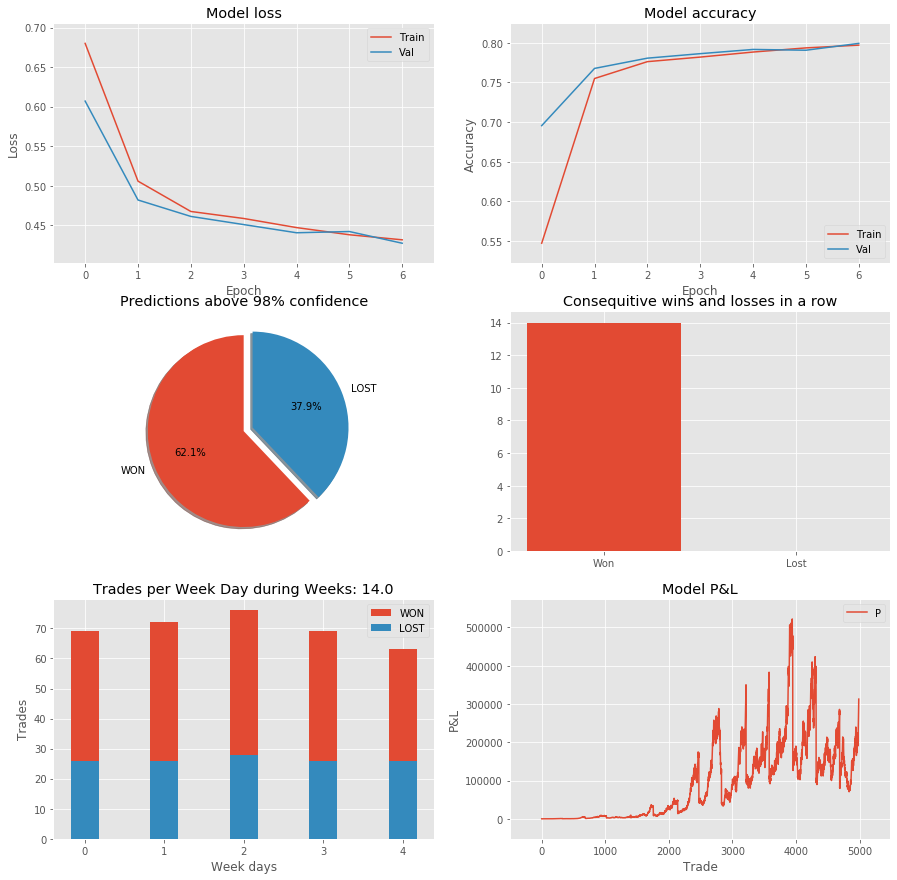

In [90]:
plt.style.use('ggplot')
f = plt.figure(figsize=(15,15))

ax = f.add_subplot(321)
ax.margins(0.1) 
ax.plot(hist.history['loss'])
ax.plot(hist.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Val'], loc='upper right')

ax2 = f.add_subplot(322)
ax2.margins(0.1) 
ax2.plot(hist.history['acc'])
ax2.plot(hist.history['val_acc'])
ax2.set_title('Model accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'], loc='lower right')

ax3 = f.add_subplot(323)
labels = 'WON', 'LOST'
sizes = [won_trades, lost_trades]
explode = (0, 0.1)  
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax3.set_title('Predictions above 98% confidence')

ax4 = f.add_subplot(324)
ax4.set_title('Consequitive wins and losses in a row')
x = ['Won','Lost']
ax4.bar(x, [max_won,max_lost])
ax4.set_xticks(x, ('Won','Lost'))

ax5 = f.add_subplot(325)
TradesWonWeekDay = (sum(week_day_trades['Monday']), sum(week_day_trades['Tuesday']),sum(week_day_trades['Wendsday']), sum(week_day_trades['Monday']), sum(week_day_trades['Friday']))
TradesLostWeekDay = (week_day_trades['Monday'][1], week_day_trades['Tuesday'][1], week_day_trades['Wendsday'][1], week_day_trades['Thursday'][1], week_day_trades['Friday'][1])
p1 = plt.bar(np.arange(5) , TradesWonWeekDay, 0.35 )
p2 = plt.bar(np.arange(5), TradesLostWeekDay, 0.35 )
ax5.set_ylabel('Trades')
ax5.set_title('Trades per Week Day during Weeks: ' + str(traded_weeks))
ax5.set_xticks(np.arange(5), ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
ax5.set_xlabel('Week days')
ax5.legend((p1[0], p2[0]), ('WON', 'LOST'))

ax6 = f.add_subplot(326)
ax6.margins(0.1) 
ax6.plot(profit_loss)
ax6.set_title('Model P&L')
ax6.set_ylabel('P&L')
ax6.set_xlabel('Trade')
ax6.legend('Profit', loc='upper right')

plt.show()



# Part 5. -  Save and load model

## save model

In [91]:
model.save("model3.h5")
print("Saved model to disk")

Saved model to disk


## load model

In [92]:
from keras.models import load_model

# load model
model = load_model('model3.h5')
# summarize model.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               21248     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 30,065
Trainable params: 30,065
Non-trainable params: 0
_________________________________________________________________


# Part 6. -  Evaluate model on other asset

### Load GBP/USD  1 minute candle data from csv.

In [93]:
%%time
ddf_pd2 = pd.read_csv('GBPUSD_2010_2018.csv')
ddf_pd2=ddf_pd2[::-1]
ddf_pd2=ddf_pd2.head(400000)

CPU times: user 5.77 s, sys: 671 ms, total: 6.44 s
Wall time: 10.5 s


In [94]:
ddf_pd2

,Gmt time,Open,High,Low,Close,Volume
3365256,31.12.2018 21:59:00.000,1.27552,1.27616,1.27526,1.27526,79.52
3365255,31.12.2018 21:58:00.000,1.27469,1.27552,1.27469,1.27552,70.44
3365254,31.12.2018 21:57:00.000,1.27474,1.27475,1.27467,1.27469,42.05
3365253,31.12.2018 21:56:00.000,1.27450,1.27473,1.27449,1.27466,34.55
3365252,31.12.2018 21:55:00.000,1.27456,1.27459,1.27437,1.27443,27.50
3365251,31.12.2018 21:54:00.000,1.27460,1.27460,1.27452,1.27453,36.59
3365250,31.12.2018 21:53:00.000,1.27456,1.27456,1.27444,1.27454,85.39
3365249,31.12.2018 21:52:00.000,1.27483,1.27486,1.27454,1.27455,36.84
3365248,31.12.2018 21:51:00.000,1.27483,1.27494,1.27473,1.27483,96.99
3365247,31.12.2018 21:50:00.000,1.27521,1.27524,1.27473,1.27483,122.29


### Create features for loaded dataset

In [95]:
%%time
ddf_pd2=FeatureEnginering(ddf_pd2)

Step 1: Time conversion to Weekday, Hour, Minute
Step 2: Calculation Body,Wicks sizes and type of candle
Step 3: Calculate MACD
Step 4: Calculate EMA 9
Step 5: Calculate RSI
Step 6: Calculate Bolinger Bands
Step 7: Generating candle backwards [Candle: 1]
Step 7: Generating candle backwards [Candle: 2]
Step 7: Generating candle backwards [Candle: 3]
Step 7: Generating candle backwards [Candle: 4]
Step 7: Generating candle backwards [Candle: 5]
Step 7: Generating candle backwards [Candle: 6]
Step 7: Generating candle backwards [Candle: 7]
Step 7: Generating candle backwards [Candle: 8]
Step 7: Generating candle backwards [Candle: 9]
Step 7: Generating candle backwards [Candle: 10]
Step 8: Generating prediction column
Step 9: Deleting waste columns
CPU times: user 7.57 s, sys: 3.06 s, total: 10.6 s
Wall time: 8.62 s


### Slice the dataset to get list of date times

In [96]:
%%time
D = ddf_pd2.values[:, :2]

CPU times: user 5.77 s, sys: 1.13 s, total: 6.9 s
Wall time: 6.75 s


### Slice and normalize the dataset to get the input format

In [97]:
%%time
min_max_scaler = preprocessing.MinMaxScaler()
X = ddf_pd2.values[:, 1:166]
X = min_max_scaler.fit_transform(X)

CPU times: user 15.2 s, sys: 4.53 s, total: 19.7 s
Wall time: 1min 48s


### Slice the dataset to get the output format

In [98]:
X

array([[0.        , 0.91304348, 0.15254237, ..., 0.14220771, 0.14363285,
        0.15074752],
       [0.        , 0.91304348, 0.13559322, ..., 0.14212959, 0.14382501,
        0.15040239],
       [0.        , 0.91304348, 0.11864407, ..., 0.14202879, 0.14399509,
        0.15003425],
       ...,
       [0.        , 0.73913043, 0.50847458, ..., 0.51432611, 0.51595622,
        0.51830043],
       [0.        , 0.73913043, 0.49152542, ..., 0.51437399, 0.51607294,
        0.5182795 ],
       [0.        , 0.73913043, 0.47457627, ..., 0.5144899 , 0.51639563,
        0.51818909]])

In [99]:
%%time
Y = ddf_pd2.values[:, 166:]
del ddf_pd2

CPU times: user 5.12 s, sys: 2.11 s, total: 7.23 s
Wall time: 25.2 s


### Make model predictions on GBP/USD dataset.

In [100]:
%%time
test_loss, test_acc = model.evaluate(X, Y)
print('Test accuracy:', test_acc)
predictions = model.predict(X)

399900/399900 [==============================] - 41s 101us/step
Test accuracy: 0.5839009752438109
CPU times: user 32.9 s, sys: 3.98 s, total: 36.9 s
Wall time: 1min 8s


### Calculate the win/loss ratio

In [101]:
won_trades,lost_trades = calculate_win_loss(0.99,predictions,Y)
print('Trades won: ' + str(won_trades) + ', Trades lost: ' + str(lost_trades))
print('Profitability: ' + str(round((won_trades*100)/(won_trades+lost_trades),2)) + '%')

Trades won: 1209, Trades lost: 20337
Profitability: 5.61%


### Calculate the max losses and wins in a row

In [102]:
max_won,max_lost = calculate_consequitive_trades(0.99,predictions,Y)
print('Max consequitive wins: ' + str(max_won) + ', Max consequitive looses: ' + str(max_lost))

Max consequitive wins: 10, Max consequitive looses: 215


### Calculate the average trades per week

In [103]:
week_day_trades,traded_weeks = calculate_week_trades(0.99,predictions,Y,D)
print('Data gathered from ' + str(traded_weeks) + ' weeks')
print('Average trades on Monday =  Won: ' + str(week_day_trades['Monday'][0]) + ', Lost: ' + str(week_day_trades['Monday'][1]))
print('Average trades on Tuesday =  Won: ' + str(week_day_trades['Tuesday'][0]) + ', Lost: ' + str(week_day_trades['Tuesday'][1]))
print('Average trades on Wendsday =  Won: ' + str(week_day_trades['Wendsday'][0]) + ', Lost: ' + str(week_day_trades['Wendsday'][1]))
print('Average trades on Thursday =  Won: ' + str(week_day_trades['Thursday'][0]) + ', Lost: ' + str(week_day_trades['Thursday'][1]))
print('Average trades on Friday =  Won: ' + str(week_day_trades['Friday'][0]) + ', Lost: ' + str(week_day_trades['Friday'][1]))

Data gathered from 56.0 weeks
Average trades on Monday =  Won: 3.0, Lost: 53.0
Average trades on Tuesday =  Won: 3.0, Lost: 63.0
Average trades on Wendsday =  Won: 4.0, Lost: 73.0
Average trades on Thursday =  Won: 4.0, Lost: 80.0
Average trades on Friday =  Won: 4.0, Lost: 74.0


### Calculate the profit and loss ratios togather with weekly withdraws

In [104]:
profit_loss,weekly_withdraws = calculate_p_and_l(0.99,predictions,Y,1.8,50,0.05,0.5)

### Plot the charts for GBP/USD simulation

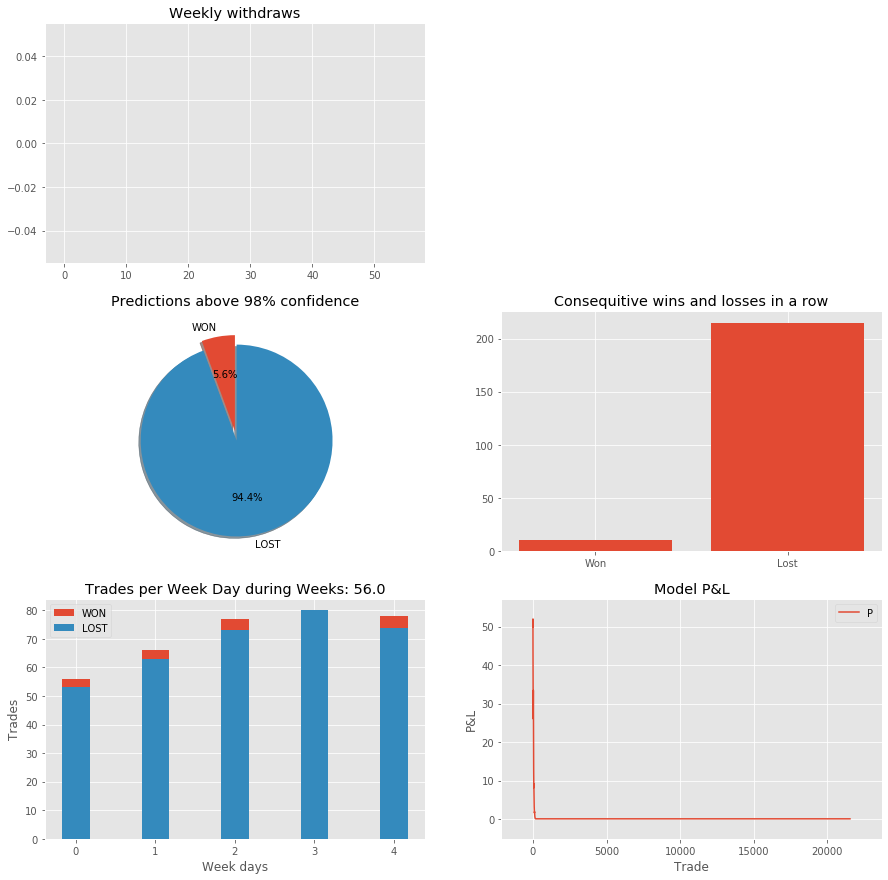

In [105]:
plt.style.use('ggplot')
f = plt.figure(figsize=(15,15))


ax1 = f.add_subplot(321)
ax1.set_title('Weekly withdraws')
ax1.bar(np.arange(len(weekly_withdraws)),weekly_withdraws)


ax3 = f.add_subplot(323)
labels = 'WON', 'LOST'
sizes = [won_trades, lost_trades]
explode = (0, 0.1)  
ax3.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax3.set_title('Predictions above 98% confidence')

ax4 = f.add_subplot(324)
ax4.set_title('Consequitive wins and losses in a row')
x = ['Won','Lost']
ax4.bar(x, [max_won,max_lost])
ax4.set_xticks(x, ('Won','Lost'))

ax5 = f.add_subplot(325)
TradesWonWeekDay = (sum(week_day_trades['Monday']), sum(week_day_trades['Tuesday']),sum(week_day_trades['Wendsday']), sum(week_day_trades['Monday']), sum(week_day_trades['Friday']))
TradesLostWeekDay = (week_day_trades['Monday'][1], week_day_trades['Tuesday'][1], week_day_trades['Wendsday'][1], week_day_trades['Thursday'][1], week_day_trades['Friday'][1])
p1 = plt.bar(np.arange(5) , TradesWonWeekDay, 0.35 )
p2 = plt.bar(np.arange(5), TradesLostWeekDay, 0.35 )
ax5.set_ylabel('Trades')
ax5.set_title('Trades per Week Day during Weeks: ' + str(traded_weeks))
ax5.set_xticks(np.arange(5), ('Monday', 'Tuesday', 'Wendsday', 'Thursday', 'Friday'))
ax5.set_xlabel('Week days')
ax5.legend((p1[0], p2[0]), ('WON', 'LOST'))

ax6 = f.add_subplot(326)
ax6.margins(0.1) 
ax6.plot(profit_loss)
ax6.set_title('Model P&L')
ax6.set_ylabel('P&L')
ax6.set_xlabel('Trade')
ax6.legend('Profit', loc='upper right')

plt.show()



## Part 7. - Make live prediction using Aplhafx API

#### data downloaded from AlphaVantage free API
API KEY: ZFO5PFRVOX72B03T

### Download live data in csv format

In [57]:
%%time
current_dataset = pd.read_csv('https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=1min&apikey=ZFO5PFRVOX72B03T&datatype=csv')

CPU times: user 32.6 ms, sys: 24.9 ms, total: 57.5 ms
Wall time: 2.72 s


### Get prediction time

In [58]:
prediction_time = current_dataset.values[0:1,0:1][0][0]

### Modified funtcion for live feature engineering

In [59]:
def FeatureEnginering_AplhaVantage(MyRawData):

    #calculate time series
    #MyRawData['WeekDay'] = ((pd.to_datetime(MyRawData['Gmt time'], format='%d.%m.%Y %H:%M:%S.000', utc=True)).dt.dayofweek.astype(dtype=np.int64)/4)
    MyRawData['timestamp'] = pd.to_datetime(MyRawData['timestamp'], format='%Y-%m-%d %H:%M:%S', utc=True)
    #MyRawData['timestamp2'] = MyRawData['timestamp2'].dt.date
    #MyRawData['timestamp2'] = pd.to_datetime(MyRawData['timestamp2'])
    MyRawData['WeekDay'] = (MyRawData['timestamp'].dt.dayofweek.astype(dtype=np.int64)/4)
    MyRawData['Hour'] = (MyRawData['timestamp'].dt.hour.astype(dtype=np.int64)/23)
    MyRawData['Minute'] = (MyRawData['timestamp'].dt.minute.astype(dtype=np.int64)/59)
    print('Step 1: Time conversion to Weekday, Hour, Minute')
    
    #calculate candle size parameters in pips
    MyRawData['BodyPips'] = abs((MyRawData['open']-MyRawData['close']) * 10000)
    MyRawData['WickUpPips'] = (abs(MyRawData['open']-MyRawData['high']) * 10000)
    MyRawData['WickDownPips'] = (abs(MyRawData['close']-MyRawData['low']) * 10000)
    #calculate candle type
    MyRawData['type'] = 0
    MyRawData.loc[MyRawData['close'] > MyRawData['open'] , 'type'] = 1
    print('Step 2: Calculation Body,Wicks sizes and type of candle')
    
    MyRawData['EmaSlow'], MyRawData['EmaFast'], MyRawData['MACD'] = moving_average_convergence(MyRawData['close'].values, nslow=26, nfast=12)                   
    print('Step 3: Calculate MACD')
    MyRawData['Ema9'] = moving_average(MyRawData['MACD'].values, 9, type='exponential')
    print('Step 4: Calculate EMA 9')
    MyRawData['RSI'] = relative_strength(MyRawData['close'].values) 
    print('Step 5: Calculate RSI')

    #create two new DataFrame columns to hold values of upper and lower Bollinger bands
    MyRawData['Rolling Mean'] = MyRawData['close'].rolling(window=21).mean()
    MyRawData['Bollinger High'] = MyRawData['close'].rolling(window=21).mean() + (MyRawData['close'].rolling(window=21).std() * 2)
    MyRawData['Bollinger Low'] = MyRawData['close'].rolling(window=21).mean() - (MyRawData['close'].rolling(window=21).std() * 2)
    print('Step 6: Calculate Bolinger Bands')
    
    #add 10 more history candle sticks
    for CandleCount in range(10):
        ActualCandleCount = CandleCount + 1
        MyRawData['BodyPips' + '_' + str(ActualCandleCount)] = MyRawData['BodyPips'].shift(-ActualCandleCount)
        MyRawData['WickUpPips' + '_' + str(ActualCandleCount)] = MyRawData['WickUpPips'].shift(-ActualCandleCount)
        MyRawData['WickDownPips' + '_' + str(ActualCandleCount)] = MyRawData['WickDownPips'].shift(-ActualCandleCount)
        MyRawData['WeekDay' + '_' + str(ActualCandleCount)] = MyRawData['WeekDay'].shift(-ActualCandleCount)
        MyRawData['Hour' + '_' + str(ActualCandleCount)] = MyRawData['Hour'].shift(-ActualCandleCount)
        MyRawData['Minute' + '_' + str(ActualCandleCount)] = MyRawData['Minute'].shift(-ActualCandleCount)
        MyRawData['type' + '_' + str(ActualCandleCount)] = MyRawData['type'].shift(-ActualCandleCount)
        MyRawData['EmaSlow' + '_' + str(ActualCandleCount)] = MyRawData['EmaSlow'].shift(-ActualCandleCount)
        MyRawData['EmaFast' + '_' + str(ActualCandleCount)] = MyRawData['EmaFast'].shift(-ActualCandleCount)
        MyRawData['MACD' + '_' + str(ActualCandleCount)] = MyRawData['MACD'].shift(-ActualCandleCount)
        MyRawData['Ema9' + '_' + str(ActualCandleCount)] = MyRawData['Ema9'].shift(-ActualCandleCount)
        MyRawData['RSI' + '_' + str(ActualCandleCount)] = MyRawData['RSI'].shift(-ActualCandleCount)
        MyRawData['Rolling Mean' + '_' + str(ActualCandleCount)] = MyRawData['Rolling Mean'].shift(-ActualCandleCount)
        MyRawData['Bollinger High' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger High'].shift(-ActualCandleCount)
        MyRawData['Bollinger Low' + '_' + str(ActualCandleCount)] = MyRawData['Bollinger Low'].shift(-ActualCandleCount)
        print('Step 7: Generating candle backwards [Candle: ' + str(ActualCandleCount) +']')


    #del MyRawData['timestamp2']
    del MyRawData['timestamp']
    del MyRawData['open']
    del MyRawData['high']
    del MyRawData['low']
    del MyRawData['close']
    print('Step 9: Deleting waste columns')

    return MyRawData



### Live feature engineering

In [60]:
%%time
current_dataset=FeatureEnginering_AplhaVantage(current_dataset)

Step 1: Time conversion to Weekday, Hour, Minute
Step 2: Calculation Body,Wicks sizes and type of candle
Step 3: Calculate MACD
Step 4: Calculate EMA 9
Step 5: Calculate RSI
Step 6: Calculate Bolinger Bands
Step 7: Generating candle backwards [Candle: 1]
Step 7: Generating candle backwards [Candle: 2]
Step 7: Generating candle backwards [Candle: 3]
Step 7: Generating candle backwards [Candle: 4]
Step 7: Generating candle backwards [Candle: 5]
Step 7: Generating candle backwards [Candle: 6]
Step 7: Generating candle backwards [Candle: 7]
Step 7: Generating candle backwards [Candle: 8]
Step 7: Generating candle backwards [Candle: 9]
Step 7: Generating candle backwards [Candle: 10]
Step 9: Deleting waste columns
CPU times: user 323 ms, sys: 8.48 ms, total: 332 ms
Wall time: 924 ms


### Show live data

In [61]:
current_dataset

,WeekDay,Hour,Minute,BodyPips,WickUpPips,WickDownPips,type,EmaSlow,EmaFast,MACD,...,Minute_10,type_10,EmaSlow_10,EmaFast_10,MACD_10,Ema9_10,RSI_10,Rolling Mean_10,Bollinger High_10,Bollinger Low_10
0,1.0,0.913043,0.000000,1.0,1.0,1.0,1,1.136965,1.136886,-7.952757e-05,...,0.847458,0.0,1.136965,1.136886,-7.952757e-05,-0.000080,70.000000,NaN,NaN,NaN
1,1.0,0.869565,1.000000,2.0,2.0,1.0,0,1.136965,1.136886,-7.952757e-05,...,0.830508,0.0,1.136965,1.136886,-7.952757e-05,-0.000080,70.000000,NaN,NaN,NaN
2,1.0,0.869565,0.983051,1.0,2.0,0.0,0,1.136965,1.136886,-7.952757e-05,...,0.813559,0.0,1.136965,1.136886,-7.952757e-05,-0.000080,70.000000,NaN,NaN,NaN
3,1.0,0.869565,0.966102,1.0,2.0,2.0,1,1.136965,1.136886,-7.952757e-05,...,0.796610,0.0,1.136965,1.136928,-3.777120e-05,-0.000077,70.000000,NaN,NaN,NaN
4,1.0,0.869565,0.949153,1.0,1.0,2.0,1,1.136965,1.136886,-7.952757e-05,...,0.779661,0.0,1.136965,1.136959,-6.371730e-06,-0.000072,70.000000,NaN,NaN,NaN
5,1.0,0.869565,0.932203,0.0,0.0,2.0,0,1.136965,1.136886,-7.952757e-05,...,0.762712,0.0,1.136965,1.136965,-6.456374e-07,-0.000066,70.000000,NaN,NaN,NaN
6,1.0,0.869565,0.915254,1.0,0.0,1.0,0,1.136965,1.136886,-7.952757e-05,...,0.745763,0.0,1.136965,1.136985,1.995623e-05,-0.000058,70.000000,NaN,NaN,NaN
7,1.0,0.869565,0.898305,2.0,0.0,1.0,0,1.136965,1.136886,-7.952757e-05,...,0.728814,0.0,1.136965,1.137022,5.684959e-05,-0.000046,70.000000,NaN,NaN,NaN
8,1.0,0.869565,0.881356,2.0,0.0,0.0,0,1.136965,1.136886,-7.952757e-05,...,0.711864,1.0,1.136965,1.137063,9.725407e-05,-0.000030,70.000000,NaN,NaN,NaN
9,1.0,0.869565,0.864407,1.0,1.0,1.0,0,1.136965,1.136886,-7.952757e-05,...,0.694915,1.0,1.136965,1.137097,1.318761e-04,-0.000010,53.354141,NaN,NaN,NaN


### Get the first row to make prediction

In [62]:
min_max_scaler = preprocessing.MinMaxScaler()
current_dataset = min_max_scaler.fit_transform(current_dataset)
current_predict = current_dataset[:1]

In [63]:
current_predict

array([[0.        , 1.        , 0.        , 0.5       , 0.33333333,
        0.25      , 1.        , 0.27506424, 0.18739109, 0.19853953,
        0.17893387, 0.85649968,        nan,        nan,        nan,
        1.        , 0.66666667, 0.25      , 0.        , 1.        ,
        1.        , 0.        , 0.27506424, 0.18739109, 0.19853953,
        0.17893387, 0.85649968,        nan,        nan,        nan,
        0.5       , 0.66666667, 0.        , 0.        , 1.        ,
        0.98305085, 0.        , 0.27506424, 0.18739109, 0.19853953,
        0.17893387, 0.85649968,        nan,        nan,        nan,
        0.5       , 0.66666667, 0.5       , 0.        , 1.        ,
        0.96610169, 1.        , 0.27506424, 0.18739109, 0.19853953,
        0.17893387, 0.85649968,        nan,        nan,        nan,
        0.5       , 0.33333333, 0.5       , 0.        , 1.        ,
        0.94915254, 1.        , 0.27506424, 0.18739109, 0.19853953,
        0.17893387, 0.85649968,        nan,     

### Make the live prediction

In [64]:
prediction_live = model.predict(current_predict)

In [65]:
print('Prediction time: ' + str(prediction_time))
if np.argmax(prediction_live[0]) == 0: Type='RED'
if np.argmax(prediction_live[0]) == 0: Type='GREEN'
if prediction_live[0][0] > 0.99999 or prediction_live[0][0] < 0.00001:
    if  Type=='RED': Action='PUT'
    if  Type=='GREEN': Action='CALL'
else:
    Action='Wait'
print('Next candle will be: ' + Type + ' for ' + str(prediction_live[0][0]) + '%')
print('Action: ' + Action)

Prediction time: 2019-06-21 21:00:00
Next candle will be: GREEN for 0.54864496%
Action: Wait


In [66]:
print('Last predictions: Next candle will be: GREEN for 0.6122487%')

Last predictions: Next candle will be: GREEN for 0.6122487%


# Total time required to run this notebook:

In [67]:
Notebook_timer.kill()

Time elapsed: 00:14:40


# https://www.quantopian.com/posts/plot-candlestick-charts-in-research

In [ ]:
fundamentals = init_fundamentals()

In [ ]:
"""Required imports"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
"""This cell defines the plot_candles function"""

def plot_candles(pricing, title=None,
                 volume_bars=False,
                 color_function=None,
                 overlays=None,
                 technicals=None,
                 technicals_titles=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      overlays: A list of additional data series to overlay on top of pricing.  Must be the same length as pricing.
      technicals: A list of additional data series to display as subplots.
      technicals_titles: A list of titles to display for each technical indicator.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    color_function = color_function or default_color
    overlays = overlays or []
    technicals = technicals or []
    technicals_titles = technicals_titles or []
    open_price = pricing['open']
    close_price = pricing['close']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    subplot_count = 1
    if volume_bars:
        subplot_count = 2
    if technicals:
        subplot_count += len(technicals)
    
    if subplot_count == 1:
        fig, ax1 = plt.subplots(1, 1)
    else:
        ratios = np.insert(np.full(subplot_count - 1, 1), 0, 3)
        fig, subplots = plt.subplots(subplot_count, 1, sharex=True, gridspec_kw={'height_ratios': ratios})
        ax1 = subplots[0]
        
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x + 0.4, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for overlay in overlays:
        ax1.plot(x, overlay)
    # Plot volume bars if needed
    if volume_bars:
        ax2 = subplots[1]
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)
    # Plot additional technical indicators
    for (i, technical) in enumerate(technicals):
        ax = subplots[i - len(technicals)] # Technical indicator plots are shown last
        ax.plot(x, technical)
        if i < len(technicals_titles):
            ax.set_title(technicals_titles[i])

In [ ]:
%%time
current_predict = pd.read_csv('https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol=EUR&to_symbol=USD&interval=15min&apikey=ZFO5PFRVOX72B03T&datatype=csv')

In [ ]:
current_predict=current_predict[::-1]

In [ ]:
current_predict

In [ ]:
#current_predict = current_predict[50:]

In [ ]:
plot_candles(current_predict, title='1 minute candles')

In [ ]:
%%time
ddf_pd = pd.read_csv('EURUSD_2010_2018.csv',nrows=100)
#ddf_pd = pd.read_csv('EURUSD_2010_2018.csv')
#ddf_pd=ddf_pd[::-1]
#ddf_pd=ddf_pd[500:530][::-1]


In [ ]:
plot_candles(ddf_pd, title='1 minute candles')